In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
import matplotlib.pyplot as plt
import json
from glob import glob
import json

# Definições iniciais

## Initializing Constants

In [2]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]

# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]

## Reading results file

In [3]:
def get_infection_site(struct_name):

    center_str = (struct_name).split("__")[-3].split("(")[-1].split(")")[0].split(",")

    center = (float(center_str[0]), float(center_str[1]))

    radius = float(struct_name.split("__")[-2].split("--")[-1].split(".pkl")[0])

    return center, radius


def read_files(path):
    file_list = sorted(glob(path + "/*"))

    speed_up_list = []
    Cl_list = []
    Cp_list = []

    for file in file_list:

        variable = lambda a: a.split("/")[-1].split("__")[0]

        if variable(file) == "Cl":
            Cl_list.append(file)

        elif variable(file) == "Cp":
            Cp_list.append(file)

        elif variable(file) == "speed_up":
            speed_up_list.append(file)

    return Cl_list, Cp_list, speed_up_list


def format_array(Cp_file, Cl_file):

    with open(Cp_file, "rb") as f:
        Cp = pk.load(f)


    with open(Cl_file, "rb") as f:
        Cl = pk.load(f)


    center, radius = get_infection_site(Cp_file)


    return Cp, Cl, center, radius


In [4]:
Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(
    Cp_list[0], Cl_list[0]
)

## Formatting input parameters

In [5]:
def get_mesh_properties(
    x_dom,
    y_dom,
    t_dom,
    h,
    k,
    verbose=True,
):

    size_x = int(((x_dom[1] - x_dom[0]) / (h)))
    size_y = int(((y_dom[1] - y_dom[0]) / (h)))
    size_t = int(((t_dom[1] - t_dom[0]) / (k)) + 1)

    if verbose:
        print(
            "Steps in time = {:d}\nSteps in space_x = {:d}\nSteps in space_y = {:d}\n".format(
                size_t,
                size_x,
                size_y,
            )
        )

    return (size_x, size_y, size_t)



In [6]:
size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)

Steps in time = 10001
Steps in space_x = 20
Steps in space_y = 20



## Input verification

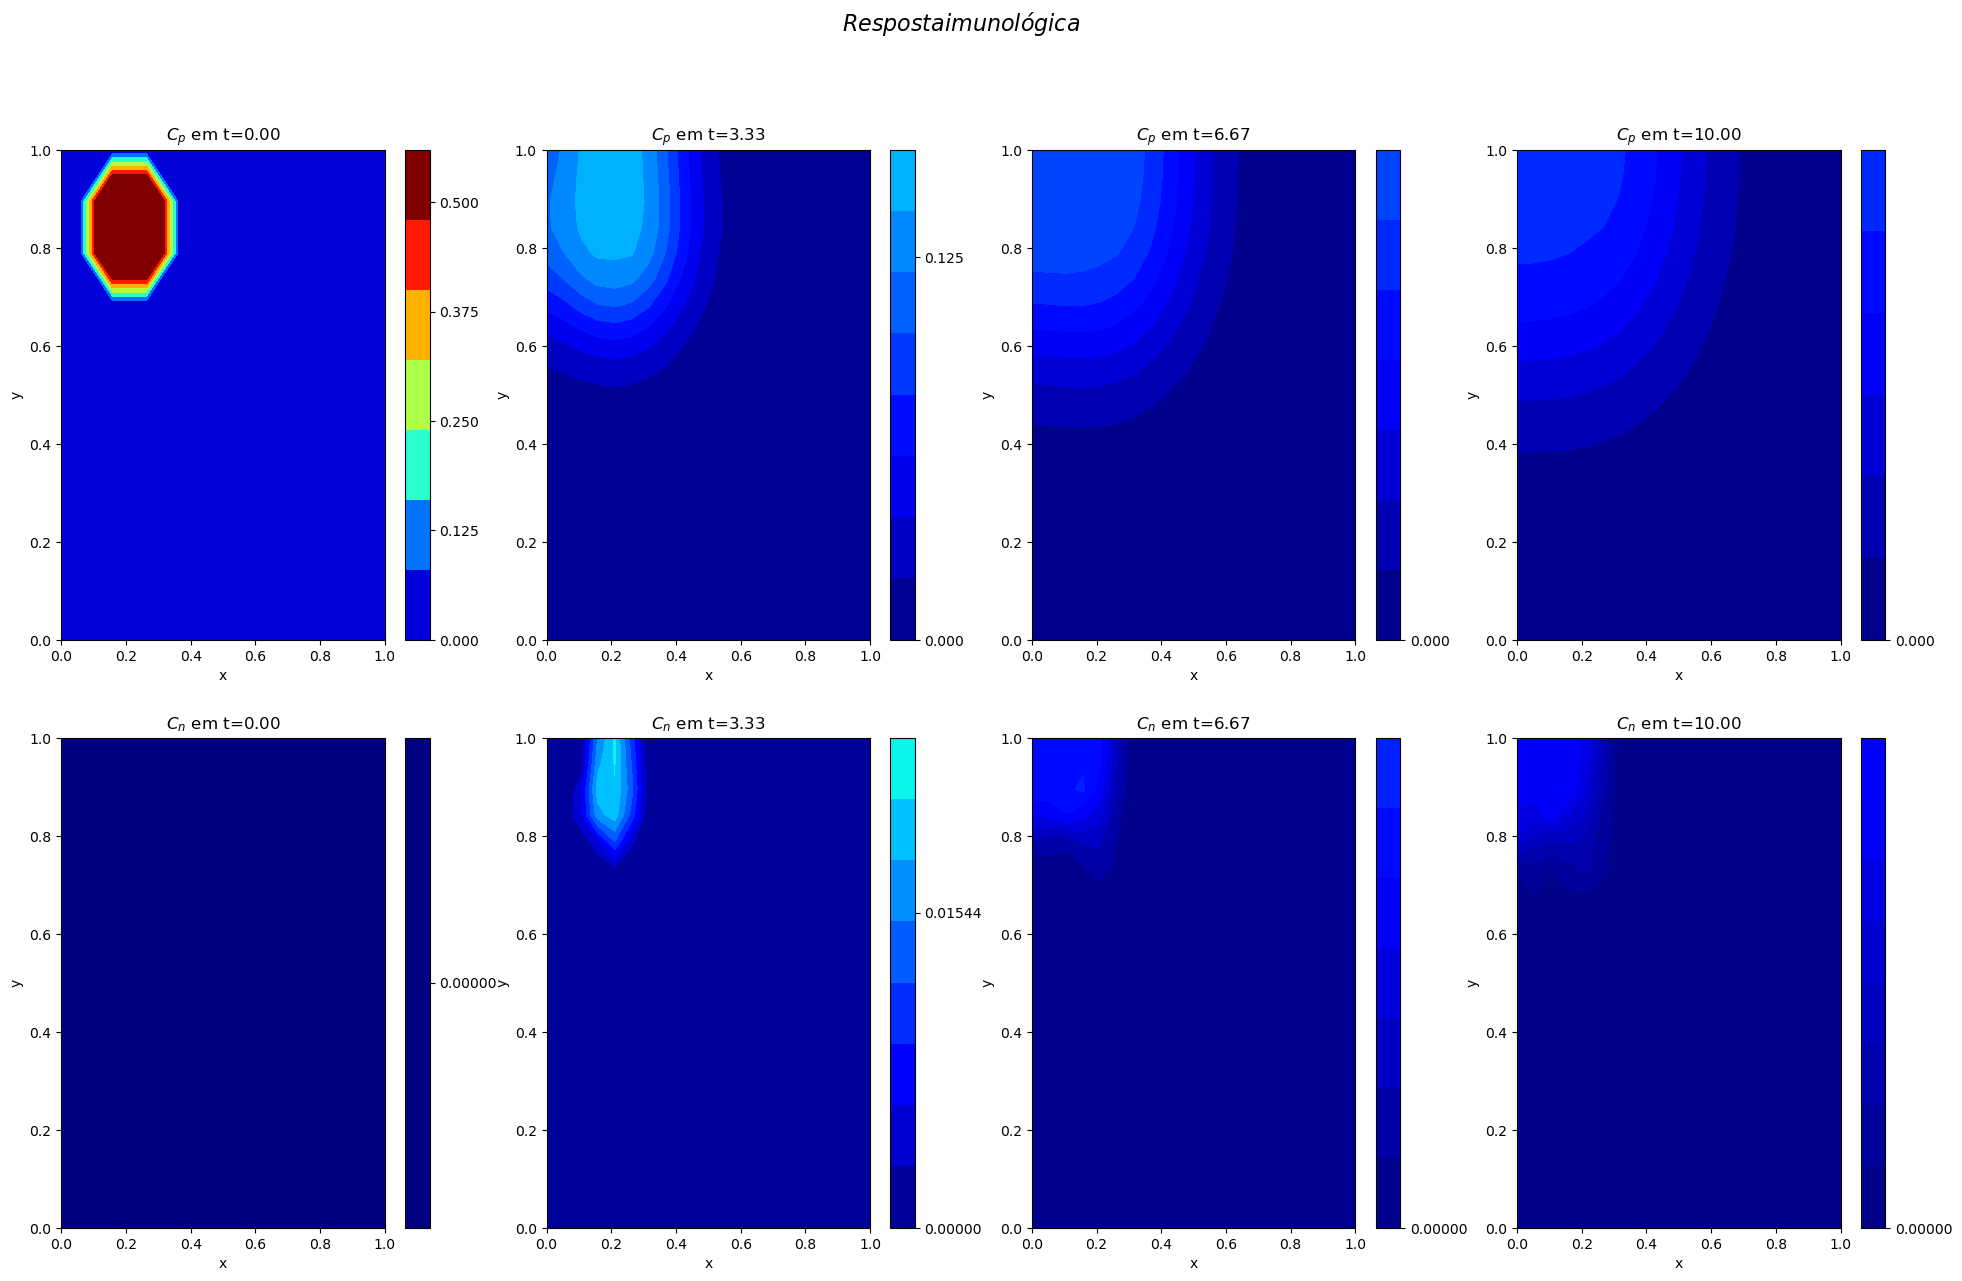

In [7]:
import matplotlib.pyplot as plt


t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)


Y, X = np.meshgrid(
    x_np,
    y_np,
)


time_plot = np.linspace(0, size_t - 1, num=4, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("$Resposta imunológica$", fontsize=16)


for i, time_inst in enumerate(time_plot):

    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cp_fvm)
    vmax = np.max(Cp_fvm)

    contour = ax.contourf(
        X,
        Y,
        Cp_fvm[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_p$ em t={:.2f}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) * 1 + 1)

    vmin = np.min(Cl_fvm)
    vmax = np.max(Cl_fvm)

    contour = ax.contourf(
        X,
        Y,
        Cl_fvm[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_n$ em t={:.2f}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))
plt.show()

## Allocate GPU memmory

In [8]:
def under_sampling(n_samples, Cl, Cp):

    choosen_points = np.linspace(
        0, len(Cl) - 1, num=n_samples, endpoint=True, dtype=int
    )

    reduced_Cl = np.zeros((n_samples, Cl.shape[1], Cl.shape[2]))

    reduced_Cp = np.zeros((n_samples, Cp.shape[1], Cl.shape[2]))

    for i, idx in enumerate(choosen_points):
        
        reduced_Cl[i, :, :] = Cl[idx, :, :]
        
        reduced_Cp[i, :, :] = Cp[idx, :, :]

    return reduced_Cl, reduced_Cp, choosen_points

In [9]:
def create_input_mesh(t_dom, x_dom, y_dom, size_t, size_x, size_y, choosen_points):

    if choosen_points.any() == None:
        t_np = np.linspace(
            t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32
        )

    else:
        t_np = np.linspace(
            t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32
        )[choosen_points]

    x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
    y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)

    x_mesh, t_mesh, y_mesh = np.meshgrid(
        x_np,
        t_np,
        y_np,
    )

    return (
        t_mesh,
        x_mesh,
        y_mesh,
    )

In [10]:
def allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center_x,
    center_y,
    initial_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    n_samples=None,
):

    choosen_points = np.array([None])

    (
        t_mesh,
        x_mesh,
        y_mesh,
    ) = create_input_mesh(t_dom, x_dom, y_dom, size_t, size_x, size_y, choosen_points)

    if torch.cuda.is_available():
        device = torch.device("cuda")

    else:
        device = "cpu"

    print("device:", device)

    initial_tc = (
        torch.tensor(initial_cond, dtype=torch.float16)
        .reshape(-1, 1)
        .requires_grad_(True)
    )

    center_x_tc = (
        torch.tensor(center_x, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    center_y_tc = (
        torch.tensor(center_y, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    radius_tc = (
        torch.tensor(radius, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)
    )

    t_tc = torch.tensor(t_mesh, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)

    x_tc = torch.tensor(x_mesh, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)

    y_tc = torch.tensor(y_mesh, dtype=torch.float32).reshape(-1, 1).requires_grad_(True)

    target = torch.tensor(
        np.array([Cl_fvm.flatten(), Cp_fvm.flatten()]).T,
        dtype=torch.float32,
    )

    if n_samples:
        reduced_Cl, reduced_Cp, choosen_points = under_sampling(
            n_samples, Cl_fvm, Cp_fvm
        )

        (
            reduced_t_mesh,
            reduced_x_mesh,
            reduced_y_mesh,
        ) = create_input_mesh(
            t_dom, x_dom, y_dom, size_t, size_x, size_y, choosen_points
        )

        reduced_t_tc = (
            torch.tensor(reduced_t_mesh, dtype=torch.float32)
            .reshape(-1, 1)
            .requires_grad_(True)
        )

        reduced_x_tc = (
            torch.tensor(reduced_x_mesh, dtype=torch.float32)
            .reshape(-1, 1)
            .requires_grad_(True)
        )

        reduced_y_tc = (
            torch.tensor(reduced_y_mesh, dtype=torch.float32)
            .reshape(-1, 1)
            .requires_grad_(True)
        )

        reduced_target = torch.tensor(
            np.array([reduced_Cl.flatten(), reduced_Cp.flatten()]).T,
            dtype=torch.float32,
        )

        return (
            initial_tc,
            center_x_tc,
            center_y_tc,
            radius_tc,
            t_tc,
            x_tc,
            y_tc,
            target,
            reduced_t_tc,
            reduced_x_tc,
            reduced_y_tc,
            reduced_target,
            device,
        )

    else:
        return (
            initial_tc,
            center_x_tc,
            center_y_tc,
            radius_tc,
            t_tc,
            x_tc,
            y_tc,
            target,
            device,
        )

In [11]:
(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_y_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center[0],
    center[1],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    1000,
)

device: cuda


## Allocation validation

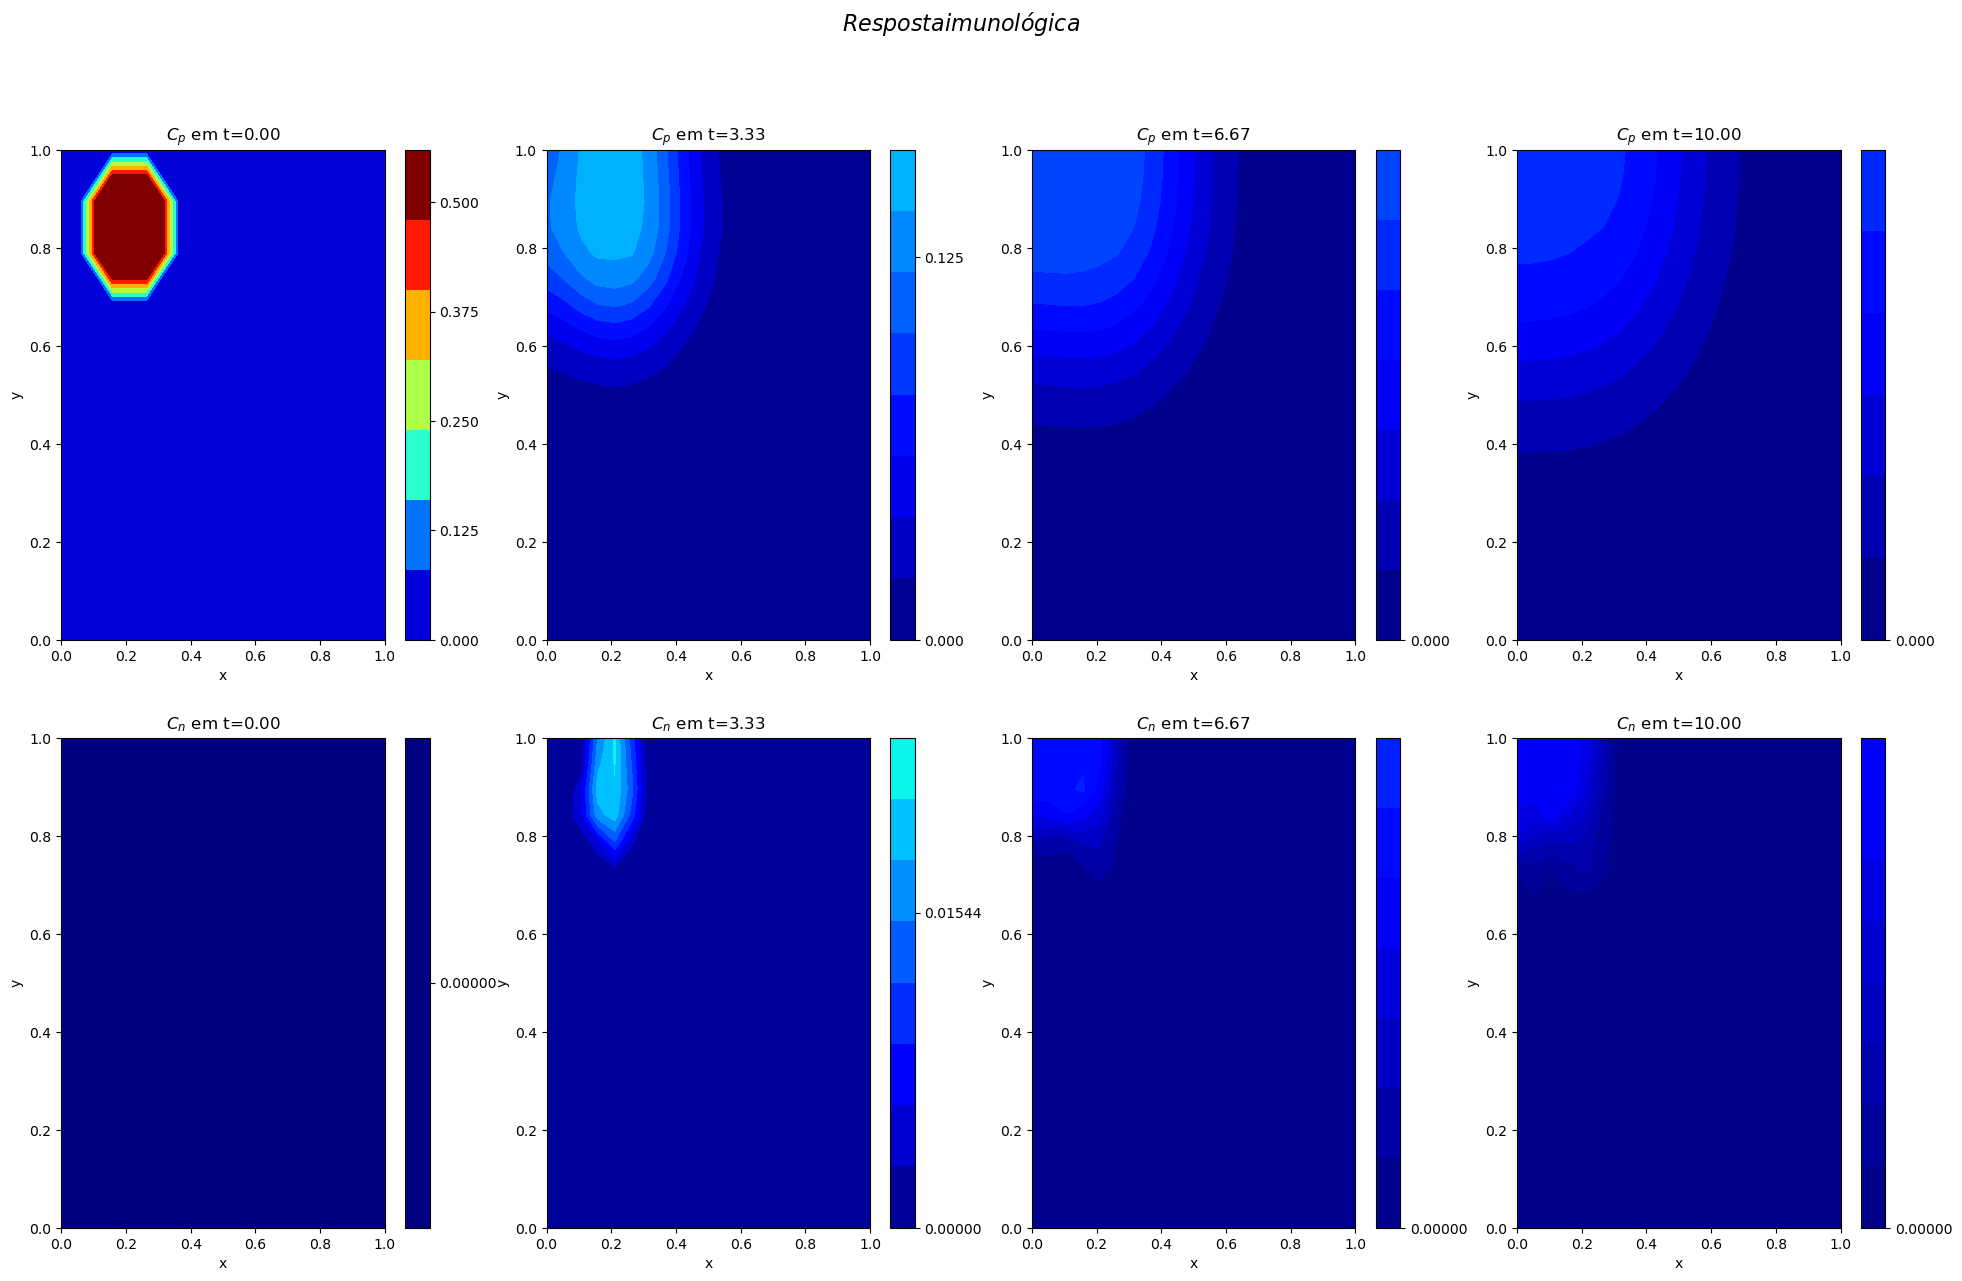

In [12]:
Cl, Cp = target.split(1, dim=1)

Cl = Cl.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp = Cp.cpu().detach().numpy().reshape(Cl_fvm.shape)

t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)


Y, X = np.meshgrid(
    x_np,
    y_np,
)


time_plot = np.linspace(0, size_t - 1, num=4, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("$Resposta imunológica$", fontsize=16)


for i, time_inst in enumerate(time_plot):

    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cp)
    vmax = np.max(Cp)

    contour = ax.contourf(
        X,
        Y,
        Cp[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_p$ em t={:.2f}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) * 1 + 1)

    vmin = np.min(Cl)
    vmax = np.max(Cl)

    contour = ax.contourf(
        X,
        Y,
        Cl[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_n$ em t={:.2f}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))
plt.show()

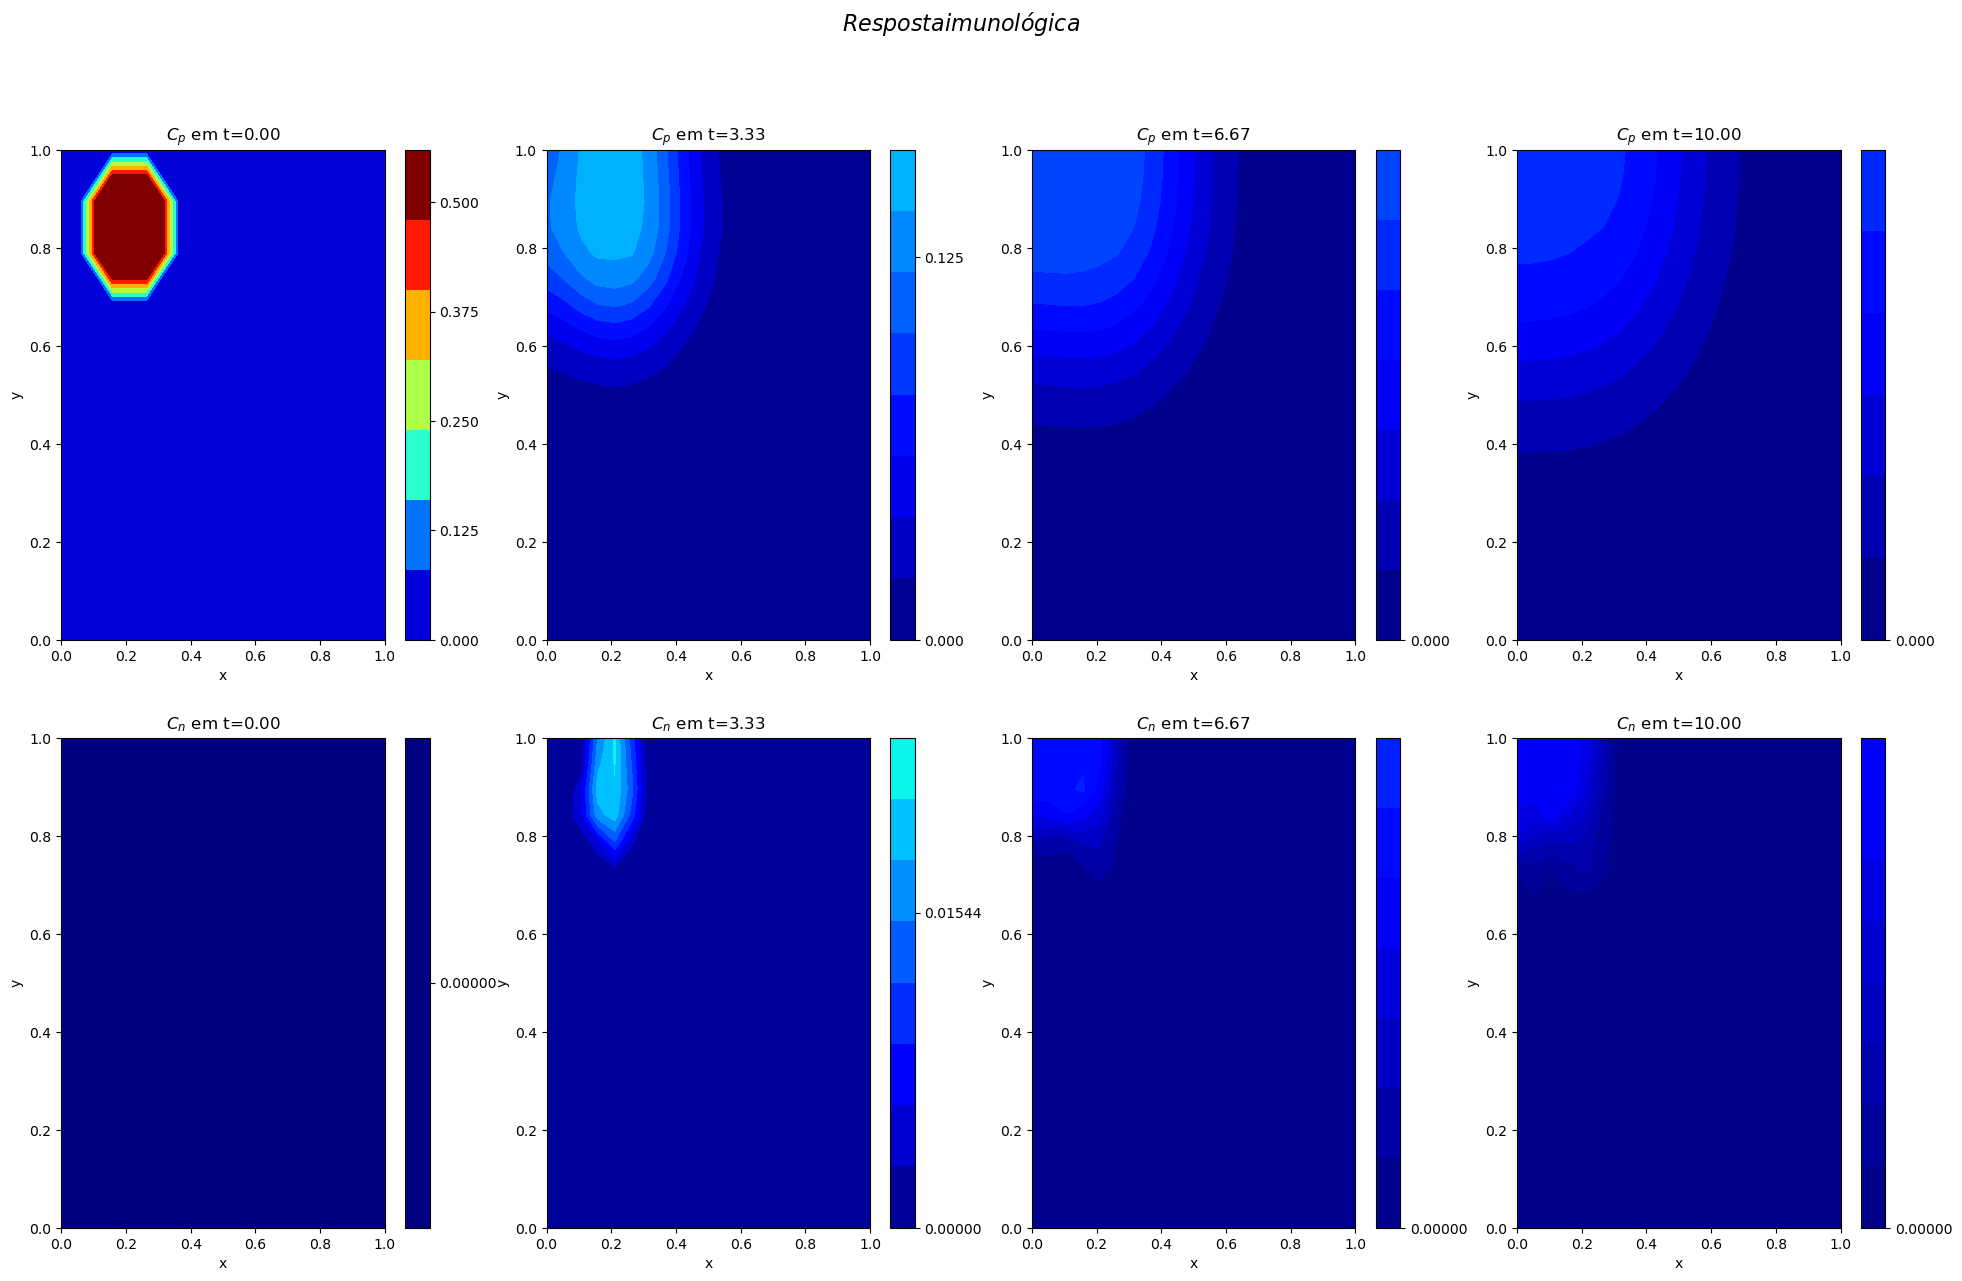

In [13]:
Cl, Cp = reduced_target.split(1, dim=1)

Cl = Cl.cpu().detach().numpy().reshape((1000, Cl_fvm.shape[1], Cl_fvm.shape[2]))
Cp = Cp.cpu().detach().numpy().reshape((1000, Cl_fvm.shape[1], Cl_fvm.shape[2]))

t_np = np.linspace(t_dom[0], t_dom[-1], num=1000, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)


Y, X = np.meshgrid(
    x_np,
    y_np,
)


time_plot = np.linspace(0, 1000 - 1, num=4, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("$Resposta imunológica$", fontsize=16)


for i, time_inst in enumerate(time_plot):

    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + 1)

    vmin = np.min(Cp)
    vmax = np.max(Cp)

    contour = ax.contourf(
        X,
        Y,
        Cp[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_p$ em t={:.2f}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(2, len(time_plot), i + len(time_plot) * 1 + 1)

    vmin = np.min(Cl)
    vmax = np.max(Cl)

    contour = ax.contourf(
        X,
        Y,
        Cl[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("$C_n$ em t={:.2f}".format(t_np[time_inst]))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))
plt.show()

# Archtecture handling

In [14]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [15]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](3, int(out_neurons)).float()
                    )

                else:
                    modules.append(nn.Linear(3, int(out_neurons)).float())
                    modules.append(activation_dict[activation]().float())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](
                            int(in_neurons), int(out_neurons)
                        ).float()
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)).float())
                    modules.append(activation_dict[activation]().float())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2).float())

    return nn.Sequential(*modules)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


# PINN

## Normalization

In [16]:
class Scaler:
    def __init__(self):

        pass

    def fit(self, dataset):
        with torch.no_grad():
            self.dt_min = torch.min(dataset, 0).values
            self.dt_max = torch.max(dataset, 0).values

    def normalize(self, dataset):

        with torch.no_grad():
            return (dataset - self.dt_min) / (self.dt_max - self.dt_min)

    def rescale(self, dataset):

        with torch.no_grad():
            return (self.dt_max - self.dt_min) * dataset + self.dt_min

    def save(self, name):

        with open("scale_weights/" + name + ".pkl", "wb") as openfile:
            # Reading from json file
            pk.dump({"min": self.dt_max, "max": self.dt_max}, openfile)

        return

    def load(self, name):

        with open("scale_weights/" + name + ".pkl", "rb") as openfile:
            # Reading from json file
            weights = pk.load(openfile)

        self.dt_min = weights["min"]
        self.dt_max = weights["max"]

        return

In [17]:
class train:
    def __init__(
        self,
        n_epochs,
        batch_size,
        decay_rate,
        model,
        center_x_tc,
        center_y_tc,
        radius_tc,
        initial_tc,
        t_tc,
        x_tc,
        y_tc,
        target,
        device,
        n_points,
        constant_properties,
        normalize=True,
        validation=None,
        tolerance=None,
        patience=10,
        lr_rate=2e-3,
    ):

        # =====================
        # 1) Basic hyperparameters and references
        # =====================
        # n_epochs: number of epochs for training
        # batch_size: how many samples per training iteration (batch)
        # decay_rate: factor for learning rate decay scheduling
        # model: the neural network (PINN model)
        # device: either CUDA or CPU device
        # n_points: number of PDE collocation points to use internally
        # validation: fraction or amount to split off for validation
        # tolerance, patience: for potential early stopping logic
        # lr_rate: initial learning rate if not otherwise specified
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate

        # Place the model on the chosen device (e.g. GPU)
        self.model = model.to(device)

        # The computational device (CPU/GPU)
        self.device = device

        # How many PDE collocation points we want to sample in the domain
        self.n_points = n_points

        # Dictionary containing PDE and domain constants (like diffusion rates, etc.)
        self.constant_properties = constant_properties

        # Validation and early-stopping parameters
        self.validation = validation
        self.tolerance = tolerance
        self.patience = patience

        # The base learning rate
        self.lr = lr_rate

        # =====================
        # 2) Normalization logic
        # =====================
        # If 'normalize=True', we fit scalers to time, x, y, and target data
        # then transform them so that PDE training is done in a normalized space.
        if normalize:
            # Create four scaler objects: for t, x, y, and the target
            t_scaler = Scaler()
            x_scaler = Scaler()
            y_scaler = Scaler()
            target_scaler = Scaler()

            # Fit each scaler to the raw data
            t_scaler.fit(t_tc)
            x_scaler.fit(x_tc)
            y_scaler.fit(y_tc)
            target_scaler.fit(target)

            # Use the fitted scalers to transform (normalize) each tensor
            t_tc = t_scaler.normalize(t_tc)
            x_tc = x_scaler.normalize(x_tc)
            y_tc = y_scaler.normalize(y_tc)
            target = target_scaler.normalize(target)

            # We now also normalize the geometry-related parameters:
            #   center_x_tc, center_y_tc, radius_tc
            # so they stay consistent with the new x/y scales.
            self.center_x_tc = x_scaler.normalize(center_x_tc.to(device))
            self.center_y_tc = y_scaler.normalize(center_y_tc.to(device))
            self.radius_tc = x_scaler.normalize(radius_tc.to(device))

            # The difference between max and min for each dimension (time, x, y, target)
            # helps with PDE derivatives in the PINN or for unnormalizing later.
            self.delta_t = t_scaler.dt_max.to(device) - t_scaler.dt_min.to(device)
            self.delta_x = x_scaler.dt_max.to(device) - x_scaler.dt_min.to(device)
            self.delta_y = y_scaler.dt_max.to(device) - y_scaler.dt_min.to(device)
            self.delta_target = (
                target_scaler.dt_max.to(device) - target_scaler.dt_min.to(device)
            )

            # Also store each dimension’s minimum for PDE transformations or denormalization
            self.t_min = t_scaler.dt_min.to(device)
            self.x_min = x_scaler.dt_min.to(device)
            self.y_min = y_scaler.dt_min.to(device)
            self.target_min = target_scaler.dt_min.to(device)

            # Convert 'initial_tc' from raw scale to normalized scale, specifically for
            # the “second dimension” of target_min/delta_target (index [1] if the shape is e.g. 2D).
            self.initial_tc = (
                (initial_tc.to(device) - self.target_min[1]) / self.delta_target[1]
            )
        else:
            # If no normalization, default to identity scaling factors.
            # This avoids messing up PDE calculations if you choose not to scale.
            self.delta_t = torch.tensor([1]).to(device)
            self.delta_x = torch.tensor([1]).to(device)
            self.delta_y = torch.tensor([1]).to(device)
            self.delta_target = torch.tensor([1]).to(device)

            self.t_min = torch.tensor([0]).to(device)
            self.x_min = torch.tensor([0]).to(device)
            self.y_min = torch.tensor([0]).to(device)
            self.target_min = torch.tensor([0]).to(device)

            # Just place geometry-related parameters on the device, no normalization
            self.center_x_tc = center_x_tc.to(device)
            self.center_y_tc = center_y_tc.to(device)
            self.radius_tc = radius_tc.to(device)
            self.initial_tc = initial_tc.to(device)

        # =====================
        # 3) Validation split logic
        # =====================
        # If a validation fraction is specified, we split data into train/test sets.
        if self.validation:
            (
                self.t_train,
                self.t_test,
                self.x_train,
                self.x_test,
                self.y_train,
                self.y_test,
                self.target_train,
                self.target_test,
            ) = self.train_test_split(
                t_tc,          # normalized or raw
                x_tc,
                y_tc,
                target,
                device,
                test_size=self.validation,
            )
        else:
            # Otherwise, everything is training data
            self.t_train = t_tc.to(device)
            self.t_test = None
            self.x_train = x_tc.to(device)
            self.x_test = None
            self.y_train = y_tc.to(device)
            self.y_test = None
            self.target_train = target.to(device)
            self.target_test = None

        # If there's test data, combine it. 
        # .requires_grad_(True) is presumably so PDE-based checks can be done,
        # but you may not need it if you only want to evaluate errors
        self.test_data = (
            torch.cat([self.t_test, self.x_test, self.y_test], dim=1)
            .requires_grad_(True)
            .to(device)
            if self.t_test is not None
            else None
        )

        # pass statement means do nothing else in the constructor
        pass

    def shuffle_data(self, t, x, y, target):
        # Create a list of indices matching the number of samples
        Data_num = np.arange(x.shape[0])

        # Shuffle the order of the indices
        np.random.shuffle(Data_num)

        # Return the input tensors reordered by the shuffled indices
        return (
            t[Data_num],
            x[Data_num],
            y[Data_num],
            target[Data_num],
        )


    def train_test_split(
        self,
        t,
        x,
        y,
        target,
        device,
        test_size=0.5,
        shuffle=True,
    ):
        with torch.no_grad():
            if shuffle:
                # Shuffle the dataset before splitting (optional)
                t, x, y, target = self.shuffle_data(t, x, y, target)

            if test_size < 1:
                # If test_size is a fraction (e.g., 0.2 for 20%)
                train_ratio = len(x) - int(len(x) * test_size)

                # Split each variable into train and test subsets
                t_train, t_test = t[:train_ratio], t[train_ratio:]
                x_train, x_test = x[:train_ratio], x[train_ratio:]
                y_train, y_test = y[:train_ratio], y[train_ratio:]
                target_train, target_test = target[:train_ratio], target[train_ratio:]

                # Move all tensors to the specified device (CPU or GPU)
                return (
                    t_train.to(device),
                    t_test.to(device),
                    x_train.to(device),
                    x_test.to(device),
                    y_train.to(device),
                    y_test.to(device),
                    target_train.to(device),
                    target_test.to(device),
                )

            elif test_size in range(1, len(x)):
                # If test_size is an integer (e.g., 100 samples for testing)
                t_train, t_test = t[test_size:], t[:test_size]
                x_train, x_test = x[test_size:], x[:test_size]
                y_train, y_test = y[test_size:], y[:test_size]
                target_train, target_test = target[test_size:], target[:test_size]

                # Move all tensors to the specified device (CPU or GPU)
                return (
                    t_train.to(device),
                    t_test.to(device),
                    x_train.to(device),
                    x_test.to(device),
                    y_train.to(device),
                    y_test.to(device),
                    target_train.to(device),
                    target_test.to(device),
                )


    def generate_training_points(self, num_points, device):
        # Generate random (uniform) points in [0, 1) for time, x, and y
        t = torch.rand(num_points, 1, dtype=torch.float32)
        x = torch.rand(num_points, 1, dtype=torch.float32)
        y = torch.rand(num_points, 1, dtype=torch.float32)

        # Set requires_grad=True so we can compute PDE derivatives using autograd
        # Move each tensor to the specified device
        return (
            t.requires_grad_(True).to(device),
            x.requires_grad_(True).to(device),
            y.requires_grad_(True).to(device),
        )


    def generate_boundary_points(self, num_points, device):
        # Create a tensor for the x-coordinate with values [0.0, 1.0],
        # repeated (num_points // 2) times, each repetition has shape (2,).
        x_boundary = torch.tensor([0.0, 1], dtype=torch.float32).repeat(
            num_points // 2, 1
        )
        
        # Create a 1D tensor with 'num_points' random values between 0 and 1 for the y-coordinate.
        y_boundary = torch.rand(num_points, dtype=torch.float32)

        # Randomly decide whether to swap x_boundary and y_boundary.
        # If torch.rand(1) > 0.5, we swap these coordinates, implying that
        # the boundary conditions are for the vertical edges vs. horizontal edges.
        if torch.rand(1) > 0.5:
            # Swap x_boundary and y_boundary, so now x_boundary becomes random
            # while y_boundary is [0, 1].
            x_boundary, y_boundary = y_boundary, x_boundary
            
            # n is the normal vector for the boundary. This defines an "up-down" boundary normal.
            # Repeated enough times to match the total points.
            n = torch.tensor([[0.0, -1.0], [0.0, 1.0]], dtype=torch.float32).repeat(
                num_points // 2, 1
            )
        else:
            # If we do not swap, then n is the normal vector for a "left-right" boundary.
            n = torch.tensor([[-1.0, 0.0], [1.0, 0.0]], dtype=torch.float32).repeat(
                num_points // 2, 1
            )

        # Reshape x_boundary and y_boundary to have shape (num_points, 1),
        # mark them to require gradient, and move them to the given device (CPU or GPU).
        return (
            x_boundary.view(-1, 1).requires_grad_(True).to(device),
            y_boundary.view(-1, 1).requires_grad_(True).to(device),
            # n is also set to require gradient and moved to device.
            n.requires_grad_(True).to(device),
        )

    def initial_condition_points(
        self, num_points, device, center_x_tc, center_y_tc, radius_tc, initial_tc
    ):
        # Generate random x and y coordinates, each of size (num_points, 1).
        # The domain is assumed to be [0,1] for both x and y, based on torch.rand.
        x_tc = torch.rand(num_points, 1, dtype=torch.float32).to(device)
        y_tc = torch.rand(num_points, 1, dtype=torch.float32).to(device)

        # Compute distances of each point (x_tc, y_tc) from the circle center (center_x_tc, center_y_tc).
        # This circle is used to define the region where the initial condition is applied.
        euclidean_distances = (
            (x_tc - center_x_tc) ** 2 + (y_tc - center_y_tc) ** 2
        ) ** 0.5

        # Create a boolean mask where True means the point is inside or on the circle
        # (distance <= radius).
        inside_circle_mask = euclidean_distances <= radius_tc

        # Prepare a (num_points, 2) tensor for storing the initial conditions.
        # By default, it is filled with zeros for both columns (Cl, Cp).
        C_init = torch.zeros((len(x_tc), 2), dtype=torch.float32)
        
        # For all points inside the circle, assign initial_tc to the second column (here, the "pathogen" column).
        # We do this by multiplying the boolean mask with the desired initial value.
        # The .ravel() ensures consistent 1D shapes for broadcasting.
        C_init[:, 1] = inside_circle_mask.ravel() * initial_tc.ravel()

        # Return the x, y coordinates and the initialized 2-column tensor (C_init).
        return x_tc, y_tc, C_init.to(device)

    def boundary_condition_optimized(self, model, device, t_b, x_b, y_b, n, Dn, X_nb, Db):
        """
        Vectorized boundary-condition function that simultaneously processes 
        all boundary points (both x-boundary and y-boundary) in one pass.
        Instead of if/else on nx[0], we do partial derivatives for x_b & y_b 
        once, then use masks to apply the correct formula to x-boundary or y-boundary points.
        """

        # 1) Forward pass through model to get Cl and Cp at boundary points
        input_data = torch.cat([t_b, x_b, y_b], dim=1).to(device)
        Cl, Cp = model(input_data).tensor_split(2, dim=1)

        # 2) Split normal vector into x- and y- components
        nx, ny = n.tensor_split(2, dim=1)

        # 3) Compute partial derivatives of Cp and Cl with respect to BOTH x_b and y_b
        #    in a single pass
        #    grad w.r.t. x_b
        dCp_dx = torch.autograd.grad(
            Cp,
            x_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )[0]  # [0] to extract the actual tensor from the tuple
        
        dCl_dx = torch.autograd.grad(
            Cl,
            x_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )[0]
        
        #    grad w.r.t. y_b
        dCp_dy = torch.autograd.grad(
            Cp,
            y_b,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )[0]
        
        dCl_dy = torch.autograd.grad(
            Cl,
            y_b,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )[0]

        # 4) Create zero-filled boundary result arrays for each quantity
        #    (i.e. the "flux" at each boundary point)
        Cp_boundary = torch.zeros_like(Cp)
        Cl_boundary = torch.zeros_like(Cl)

        # 5) Build masks for which points are x-boundary vs. y-boundary
        #    We interpret "vertical boundary" as nx != 0, "horizontal" as ny != 0.
        #    Typically, exactly one of them is nonzero. (Corner or partial mismatch 
        #    would require a further check.)
        x_mask = (nx != 0).flatten()
        y_mask = (ny != 0).flatten()

        # 6) Fill boundary conditions for x‑boundary points
        #    If your code uses the property self.delta_target, self.delta_x, etc., 
        #    be sure these are expanded or broadcasted properly to match shapes
        #    for indexing.
        if x_mask.any():
            # Those boundary points are "vertical" boundary => formula uses d/dx
            # We'll just do inlined multiplications, same as original snippet
            Cp_boundary_x = (- Db * self.delta_target[1] * dCp_dx[x_mask] / self.delta_x) * nx[x_mask]
            Cl_boundary_x = (
                (Dn * self.delta_target[0] * dCl_dx[x_mask] / self.delta_x)
                - X_nb * self.delta_target[1] * Cl[x_mask] * (dCp_dx[x_mask] / self.delta_x)
            ) * nx[x_mask]

            # Place them in the global arrays at the appropriate subset
            Cp_boundary[x_mask] = Cp_boundary_x
            Cl_boundary[x_mask] = Cl_boundary_x

        # 7) Fill boundary conditions for y‑boundary points
        if y_mask.any():
            # Those boundary points are "horizontal" boundary => formula uses d/dy
            Cp_boundary_y = (Db * self.delta_target[1] * dCp_dy[y_mask] / self.delta_y) * ny[y_mask]
            Cl_boundary_y = (
                (Dn * self.delta_target[0] * dCl_dy[y_mask] / self.delta_y)
                - X_nb * self.delta_target[1] * Cl[y_mask] * (dCp_dy[y_mask] / self.delta_y)
            ) * ny[y_mask]

            # Place them in the global arrays
            Cp_boundary[y_mask] = Cp_boundary_y
            Cl_boundary[y_mask] = Cl_boundary_y

        # 8) Finally, return the concatenation
        return torch.cat([Cl_boundary, Cp_boundary], dim=1)

    def pde(
        self,
        model,
        t,
        x,
        y,
        cb,
        phi,
        lambd_nb,
        Db,
        y_n,
        Cn_max,
        lambd_bn,
        mi_n,
        Dn,
        X_nb,
    ):

        Cl, Cp = model(torch.cat([t, x, y], dim=1)).tensor_split(2, dim=1)

        # Calculating Cp value

        dCp_dx, dCp_dy = torch.autograd.grad(
            Cp,
            [x, y],
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )

        dCp_dx_2 = torch.autograd.grad(
            dCp_dx,
            x,
            grad_outputs=torch.ones_like(dCp_dx),
            create_graph=True,
            retain_graph=True,
        )[0]

        dCp_dy_2 = torch.autograd.grad(
            dCp_dy,
            y,
            grad_outputs=torch.ones_like(dCp_dy),
            create_graph=True,
            retain_graph=True,
        )[0]

        dCp_dt = torch.autograd.grad(
            Cp,
            t,
            grad_outputs=torch.ones_like(Cp),
            create_graph=True,
            retain_graph=True,
        )[0]

        qb = cb * (Cp * self.delta_target[1] + self.target_min[1])
        rb = lambd_nb * torch.mul(
            Cl * self.delta_target[0] + self.target_min[0],
            Cp * self.delta_target[1] + self.target_min[1],
        )

        Cp_eq = (
            Db * (dCp_dx_2 / self.delta_x**2 + dCp_dy_2 / self.delta_y**2)
            - rb
            + qb
            - dCp_dt * phi / self.delta_t
        )

        # Calculating Cl value

        dCl_dx, dCl_dy = torch.autograd.grad(
            Cl,
            [x, y],
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )

        dCl_dx_2 = torch.autograd.grad(
            dCl_dx,
            x,
            grad_outputs=torch.ones_like(dCl_dx),
            create_graph=True,
            retain_graph=True,
        )[0]

        dCl_dy_2 = torch.autograd.grad(
            dCl_dy,
            y,
            grad_outputs=torch.ones_like(dCl_dy),
            create_graph=True,
            retain_graph=True,
        )[0]

        dCl_dt = torch.autograd.grad(
            Cl,
            t,
            grad_outputs=torch.ones_like(Cl),
            create_graph=True,
            retain_graph=True,
        )[0]

        qn = y_n * torch.mul(
            Cp * self.delta_target[1] + self.target_min[1],
            (Cn_max - Cl * self.delta_target[0] - self.target_min[0]),
        )

        rn = torch.mul(
            Cl * self.delta_target[0] + self.target_min[0],
            lambd_bn * (Cp * self.delta_target[1] + self.target_min[1]) + mi_n,
        )

        Cl_eq = (
            Dn * (dCl_dx_2 / self.delta_x**2 + dCl_dy_2 / self.delta_y**2)
            - X_nb
            * (
                self.delta_target[1]
                * (
                    torch.mul(dCl_dx, dCp_dx) / self.delta_x**2
                    + (torch.mul(dCl_dy, dCp_dy) / self.delta_y**2)
                    + torch.mul(
                        (self.delta_target[0] * Cl + self.target_min[0])
                        / self.delta_target[0],
                        (dCp_dx_2 / self.delta_x**2 + dCp_dy_2 / self.delta_y**2),
                    )
                )
            )
            - rn
            + qn
        ) - dCl_dt * phi / self.delta_t

        return torch.cat([Cl_eq, Cp_eq], dim=1)

    def loss_func(
        self,
    ):

        self.batch = torch.cat(
            [
                self.t_train,
                self.x_train,
                self.y_train,
            ],
            dim=1,
        )[self.i : self.i + self.batch_size, :]

        x_ini, y_ini, initial_target = self.initial_condition_points(
            self.batch_size,
            self.device,
            self.center_x_tc,
            self.center_y_tc,
            self.radius_tc,
            self.initial_tc,
        )

        # Computing intial loss
        t_initial = torch.zeros((self.batch_size, 1), dtype=torch.float32).to(
            self.device
        )

        mesh_ini = torch.cat(
            [t_initial, x_ini, y_ini],
            dim=1,
        )

        initial_pred = self.model(mesh_ini)

        self.loss_initial = self.criterion(initial_target, initial_pred)

        # Computing pde loss

        t, x, y = self.generate_training_points(self.n_points, self.device)

        predicted_pde = self.pde(
            self.model,
            t,
            x,
            y,
            self.constant_properties["phi"],
            self.constant_properties["cb"],
            self.constant_properties["lambd_nb"],
            self.constant_properties["Db"],
            self.constant_properties["y_n"],
            self.constant_properties["Cn_max"],
            self.constant_properties["lambd_bn"],
            self.constant_properties["mi_n"],
            self.constant_properties["Dn"],
            self.constant_properties["X_nb"],
        )

        self.loss_pde = self.criterion(
            predicted_pde,
            torch.zeros_like(predicted_pde),
        )

        # Computing boundary loss

        x_bnd, y_bnd, n_bnd = self.generate_boundary_points(self.n_points, self.device)

        predicted_boundary = self.boundary_condition(
            self.model,
            self.device,
            t,
            x_bnd,
            y_bnd,
            n_bnd,
            self.constant_properties["Dn"],
            self.constant_properties["X_nb"],
            self.constant_properties["Db"],
        )

        self.loss_boundary = self.criterion(
            predicted_boundary,
            torch.zeros_like(predicted_boundary),
        )

        # Computing data loss

        C_pred = self.model(self.batch.to(self.device))

        self.loss_data = self.criterion(
            C_pred, self.target_train[self.i : self.i + self.batch_size, :]
        )

        self.C_pred = C_pred

        del C_pred

        return self.loss_initial + self.loss_pde + self.loss_boundary + self.loss_data

    def execute(
        self,
    ):
        self.criterion = nn.MSELoss()

        self.optimizer = optim.Adam(
            self.model.parameters(), lr=self.lr, betas=(0.9, 0.95)
        )
        self.lr_scheduler = optim.lr_scheduler.ExponentialLR(
            optimizer=self.optimizer, gamma=self.decay_rate
        )
        C_pde_loss_it = torch.zeros(self.n_epochs)
        C_data_loss_it = torch.zeros(self.n_epochs)
        C_boundary_loss_it = torch.zeros(self.n_epochs)
        C_initial_loss_it = torch.zeros(self.n_epochs)
        val_loss_it = torch.zeros(self.n_epochs)

        patience_count = 0
        val_loss = torch.tensor([1000])

        for epoch in range(self.n_epochs):
            for self.i in range(0, len(self.x_train), self.batch_size):

                self.optimizer.zero_grad()

                loss = self.loss_func()

                loss.backward()

                self.optimizer.step()

            self.lr_scheduler.step()

            # Computing validation loss

            if self.validation:
                with torch.no_grad():
                    val_old = val_loss.clone()
                    val_loss = self.criterion(
                        self.target_test, self.model(self.test_data)
                    )

            C_pde_loss_it[epoch] = self.loss_pde.item()
            C_boundary_loss_it[epoch] = self.loss_boundary.item()
            C_initial_loss_it[epoch] = self.loss_initial.item()
            C_data_loss_it[epoch] = self.loss_data.item()
            val_loss_it[epoch] = val_loss.item() if self.validation else 0

            if ((epoch + 1) % 50) == 0 or (epoch == 0):

                print(
                    f"Finished epoch {epoch+1}, latest loss {loss}, validation loss {val_loss.item()}"
                    if self.validation
                    else f"Finished epoch {epoch+1}, latest loss {loss}"
                )

            if self.tolerance:

                if (
                    abs(val_old.item() - val_loss.item()) / val_old.item()
                    < self.tolerance
                ):
                    patience_count += 1

                else:
                    patience_count = 0

                if patience_count >= self.patience:

                    C_pde_loss_it = C_pde_loss_it[:epoch]
                    C_boundary_loss_it = C_boundary_loss_it[:epoch]
                    C_initial_loss_it = C_initial_loss_it[:epoch]
                    C_data_loss_it = C_data_loss_it[:epoch]
                    val_loss_it = val_loss_it[:epoch]

                    print("Early break!")

                    break

        return (
            self.model,
            C_pde_loss_it,
            C_boundary_loss_it,
            C_initial_loss_it,
            C_data_loss_it,
            val_loss_it,
        )

## Training

In [18]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__Tanh--32"

model = generate_model(arch_str).to(device).apply(init_weights)

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [19]:
decay_rate = 0.95
n_epochs = 300
val = 0.2
batch_size = int(len(t_tc) * (1 - val) / 10)

trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial_tc=initial_tc,
    center_x_tc=center_x_tc,
    center_y_tc=center_y_tc,
    radius_tc=radius_tc,
    t_tc=reduced_t_tc,
    x_tc=reduced_x_tc,
    y_tc=reduced_y_tc,
    target=reduced_target,
    device=device,
    n_points=batch_size,
    constant_properties=constant_properties,
    validation=val,
    tolerance=0.005,
    patience=20,
    normalize=True,
    lr_rate=1e-3
)

In [20]:
(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()


Finished epoch 1, latest loss 0.05931747704744339, validation loss 0.021424639970064163
Finished epoch 50, latest loss 0.009338459931313992, validation loss 0.0037972438149154186
Early break!


## Validation

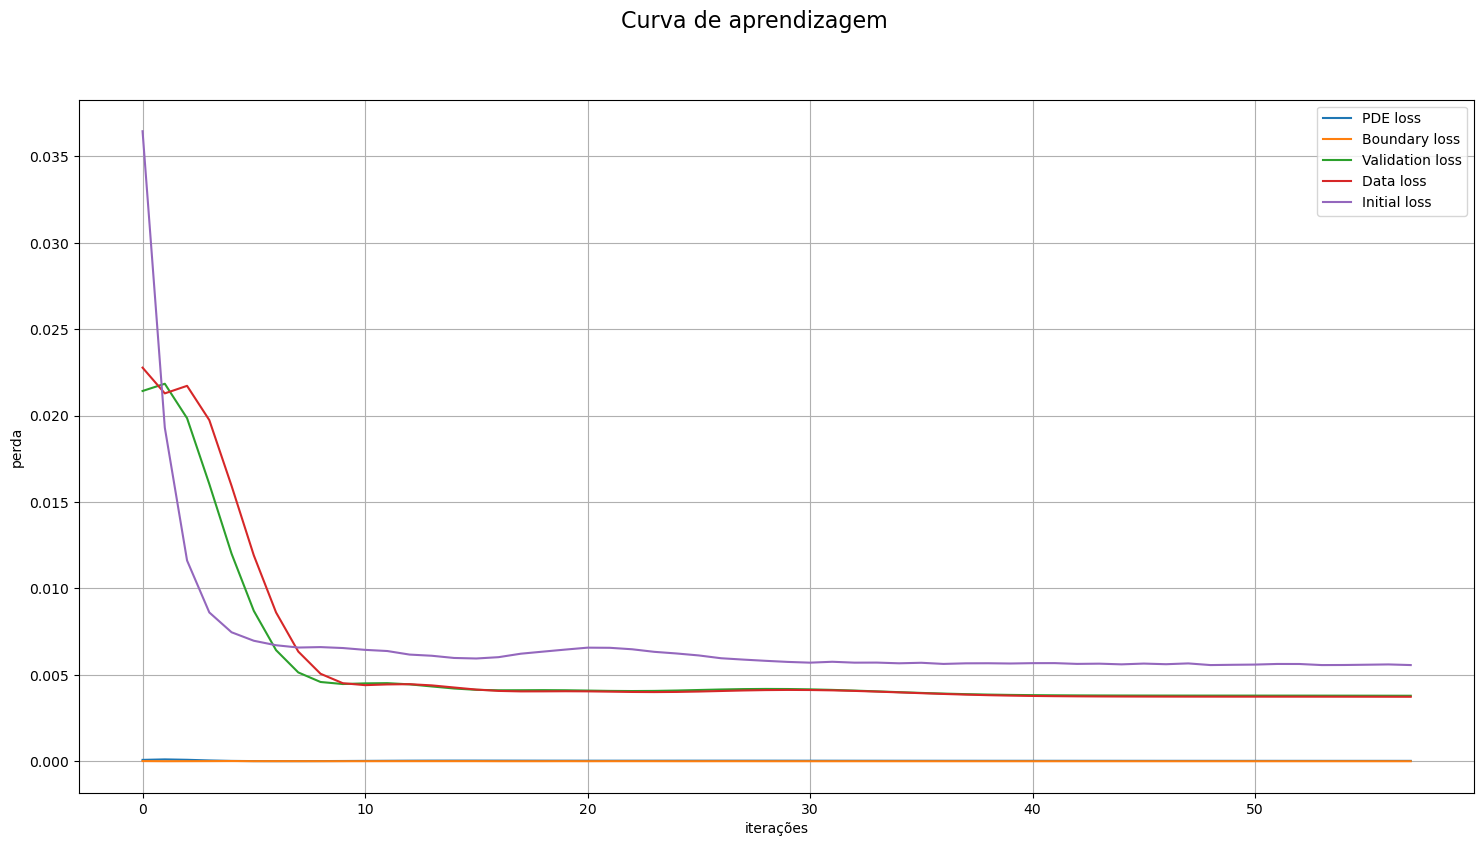

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)

ax.plot(
    range(len(C_boundary_loss_it.cpu().numpy())),
    C_boundary_loss_it.cpu().numpy(),
    label="Boundary loss",
)

ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)

ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

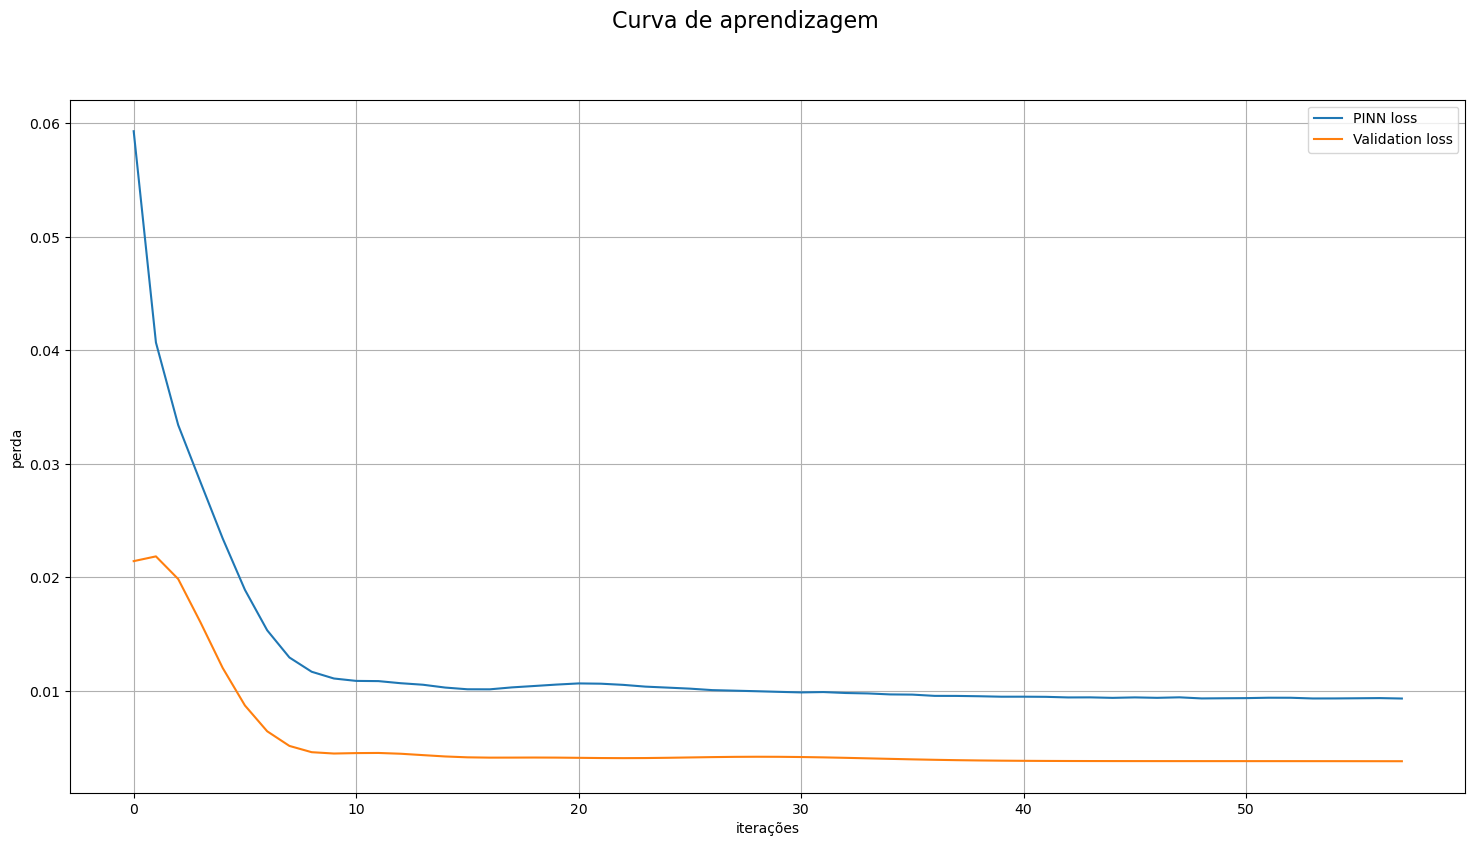

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy()
    + C_pde_loss_it.cpu().numpy()
    + C_boundary_loss_it.cpu().numpy()
    + C_data_loss_it.cpu().numpy(),
    label="PINN loss",
)
ax.plot(
    range(len(val_loss_it.cpu().numpy())),
    val_loss_it.cpu().numpy(),
    label="Validation loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [23]:
t_scaler = Scaler()
x_scaler = Scaler()
y_scaler = Scaler()
target_scaler = Scaler()

t_scaler.fit(t_tc)
x_scaler.fit(x_tc)
y_scaler.fit(y_tc)
target_scaler.fit(target)

norm_t_tc = t_scaler.normalize(t_tc)
norm_x_tc = x_scaler.normalize(x_tc)
norm_y_tc = y_scaler.normalize(y_tc)
norm_target = target_scaler.normalize(target)

mesh = torch.cat([norm_t_tc, norm_x_tc, norm_y_tc], dim=1).to(device)

with torch.no_grad():
    pred_pinn_dev = model(mesh)

pred_pinn = pred_pinn_dev.cpu().detach().numpy()

In [24]:
Cl_pinn_device, Cp_pinn_device = pred_pinn_dev.split(1, dim=1)

Cl_pinn_np = Cl_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp_pinn_np = Cp_pinn_device.cpu().detach().numpy().reshape(Cl_fvm.shape)

Cl_target_dev, Cp_target_dev = norm_target.split(1, dim=1)

Cl_target_np = Cl_target_dev.cpu().detach().numpy().reshape(Cl_fvm.shape)
Cp_target_np = Cp_target_dev.cpu().detach().numpy().reshape(Cl_fvm.shape)

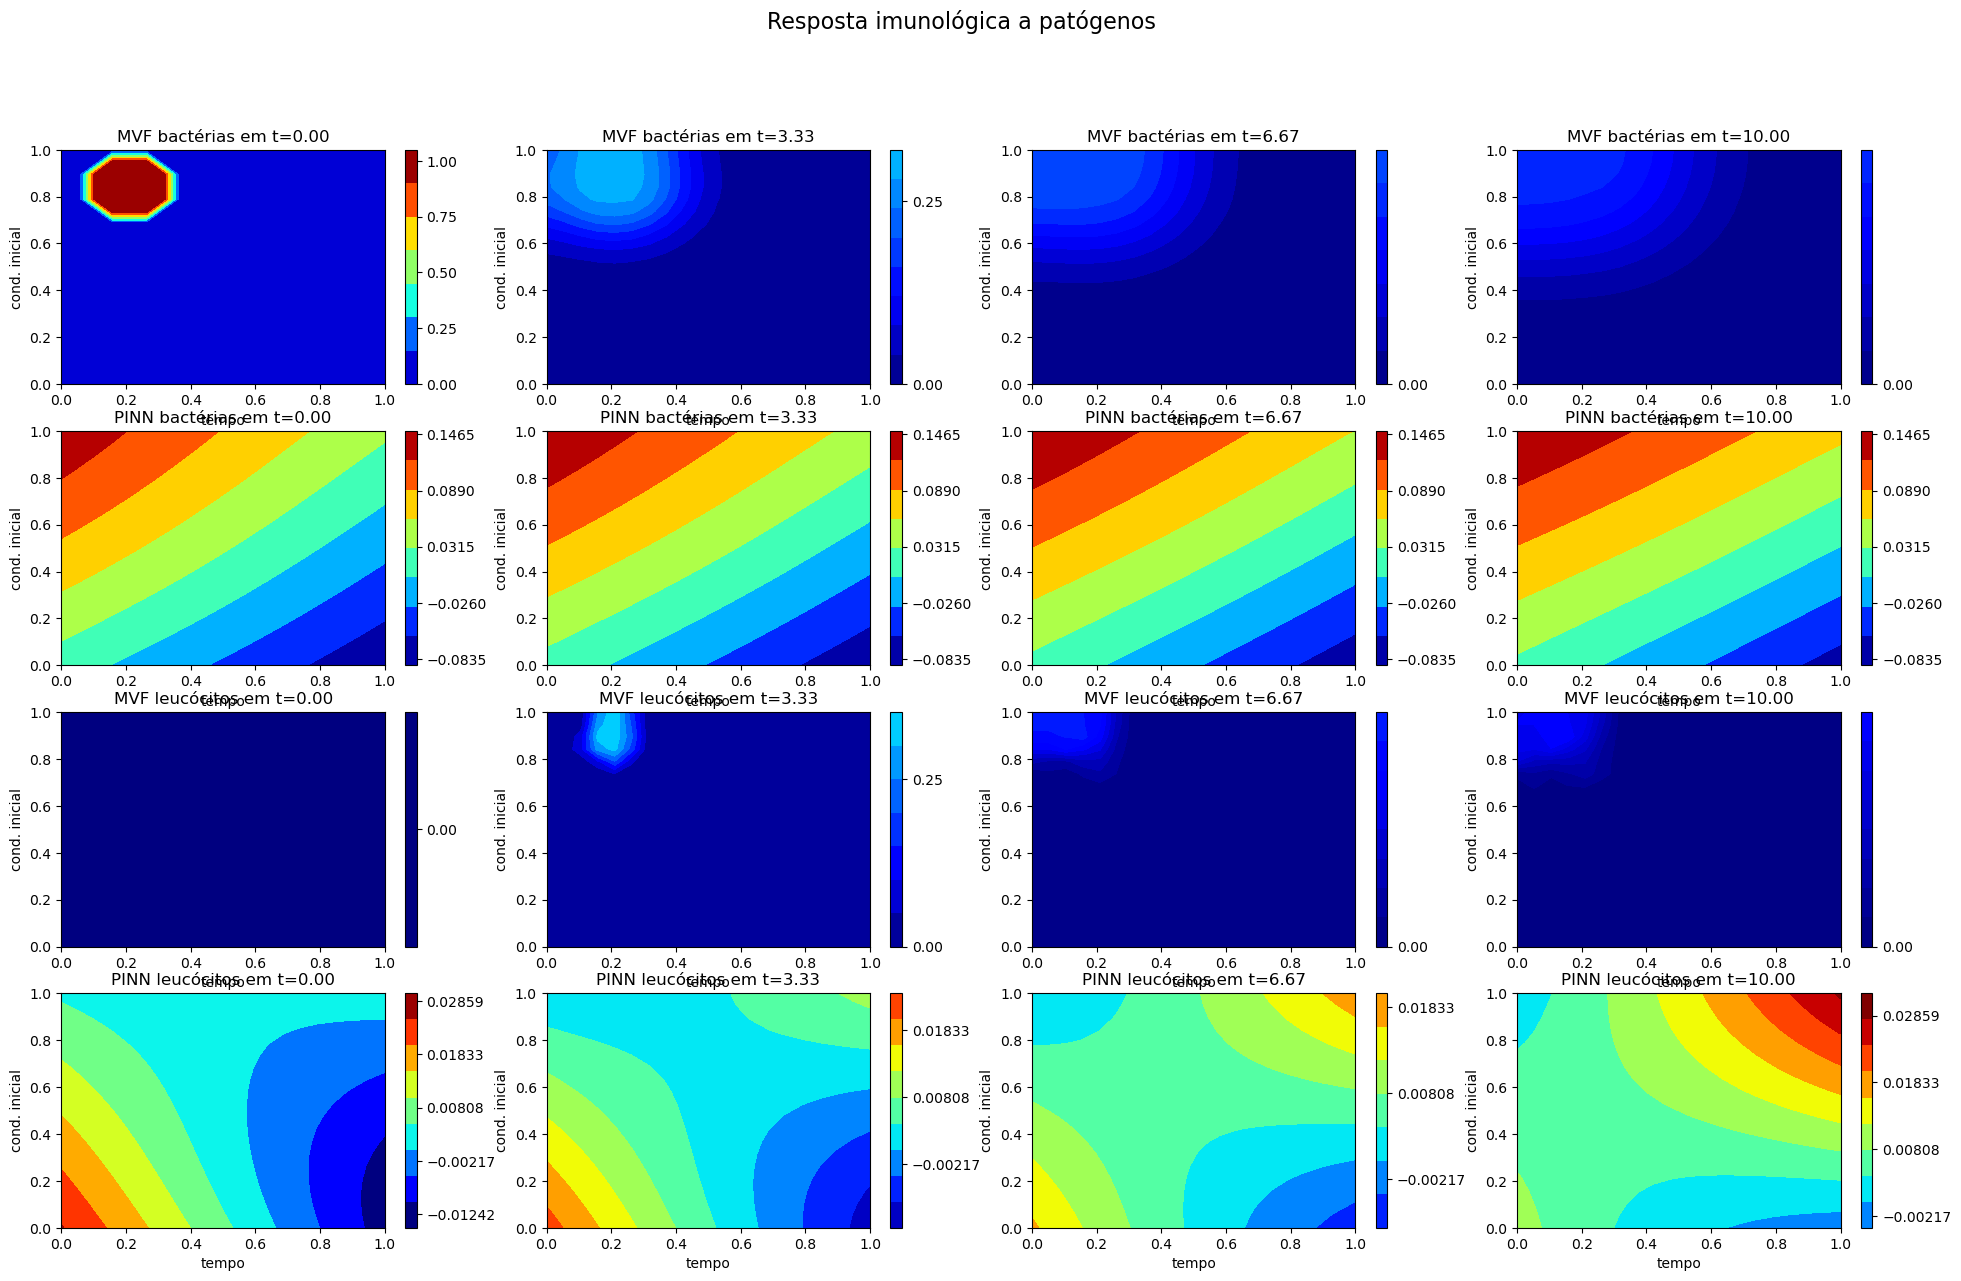

In [25]:
t_np = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x_np = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y_np = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)


Y, X = np.meshgrid(
    x_np,
    y_np,
)

time_plot = np.linspace(0, size_t - 1, num=4, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + 1)

    vmin = np.min(Cp_target_np)
    vmax = np.max(Cp_target_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_target_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("MVF bactérias em t={:.2f}".format(t_np[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN bactérias em t={:.2f}".format(t_np[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 2 + 1)

    vmin = np.min(Cl_target_np)
    vmax = np.max(Cl_target_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_target_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("MVF leucócitos em t={:.2f}".format(t_np[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))


for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 3 + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN leucócitos em t={:.2f}".format(t_np[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

## Saving model weights and biases

In [27]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
0.weight 	 torch.Size([32, 3])
0.bias 	 torch.Size([32])
2.weight 	 torch.Size([32, 32])
2.bias 	 torch.Size([32])
4.weight 	 torch.Size([32, 32])
4.bias 	 torch.Size([32])
6.weight 	 torch.Size([32, 32])
6.bias 	 torch.Size([32])
8.weight 	 torch.Size([2, 32])
8.bias 	 torch.Size([2])


In [28]:
import os

pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

del model
del trainer

# Training setup

In [6]:
import torch
import pickle as pk
import argparse
import os
import json
from pinn import *

# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]


# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])


size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)


(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_y_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center[0],
    center[1],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    3000,
)


arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

model = generate_model(arch_str).to(device).apply(init_weights)

print(model)

decay_rate = 0.9985
n_epochs = 300
val = 0.2
batch_size = int(len(t_tc) * (1 - val) / 10)
lr_rate = 6e-4

trainer = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    initial_tc=initial_tc,
    center_x_tc=center_x_tc,
    center_y_tc=center_y_tc,
    radius_tc=radius_tc,
    t_tc=reduced_t_tc,
    x_tc=reduced_x_tc,
    y_tc=reduced_y_tc,
    target=reduced_target,
    device=device,
    n_points=batch_size,
    constant_properties=constant_properties,
    validation=val,
    tolerance=0.02,
    patience=20,
    normalize=True,
    lr_rate=lr_rate,
)


(
    model,
    C_pde_loss_it,
    C_boundary_loss_it,
    C_initial_loss_it,
    C_data_loss_it,
    val_loss_it,
) = trainer.execute()


# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

pinn_file = (
    "decay_rates_{:.4}__lr_rates_{:.4}__arch_".format(decay_rate, lr_rate) + arch_str
)

cwd = os.getcwd()

torch.save(model.state_dict(), cwd + "/nn_parameters/" + pinn_file + ".pt")

with open("learning_curves/C_pde_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_pde_loss_it.cpu().numpy(), openfile)

with open("learning_curves/C_boundary_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_boundary_loss_it.cpu().numpy(), openfile)


with open("learning_curves/C_initial_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_initial_loss_it.cpu().numpy(), openfile)


with open("learning_curves/C_data_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(C_data_loss_it.cpu().numpy(), openfile)


with open("learning_curves/val_loss_it_" + pinn_file + ".pkl", "wb") as openfile:
    # Reading from json file
    pk.dump(val_loss_it.cpu().numpy(), openfile)

del model
del trainer

Steps in time = 10001
Steps in space_x = 20
Steps in space_y = 20

device: cuda
Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)
Finished epoch 1, latest loss 0.45497769117355347, validation loss 0.02281537652015686
Early break!
Model's state_dict:
0.weight 	 torch.Size([32, 3])
0.bias 	 torch.Size([32])
2.weight 	 torch.Size([32, 32])
2.bias 	 torch.Size([32])
4.weight 	 torch.Size([32, 32])
4.bias 	 torch.Size([32])
6.weight 	 torch.Size([32, 32])
6.bias 	 torch.Size([32])
8.weight 	 torch.Size([2, 32])
8.bias 	 torch.Size([2])


# Evaluation setup

In [1]:
from glob import glob
import time
import pickle as pk
import os
import json
from pinn import *

In [2]:
def load_model(file_name, device):
    cwd = os.getcwd()

    arch_str = (
        ("__")
        .join(file_name.split("/")[-1].split(".pt")[0].split("__")[2:])
        .split("arch_")[-1]
    )

    model = generate_model(arch_str).to(device)

    model.load_state_dict(
        torch.load(cwd + "/" + file_name, weights_only=True, map_location=device)
    )

    print(model.eval())

    return model


def read_speed_ups(speed_up_list):
    speed_up_obj = {}
    for i, file in enumerate(speed_up_list):
        with open(file, "rb") as f:
            speed_up_obj[i] = pk.load(f)

    return speed_up_obj

In [3]:
# Opening JSON file
with open("control_dicts/constant_properties.json", "r") as openfile:
    # Reading from json file
    constant_properties = json.load(openfile)

Db = constant_properties["Db"]
Dn = constant_properties["Dn"]
phi = constant_properties["phi"]
cb = constant_properties["cb"]
lambd_nb = constant_properties["lambd_nb"]
mi_n = constant_properties["mi_n"]
lambd_bn = constant_properties["lambd_bn"]
y_n = constant_properties["y_n"]
Cn_max = constant_properties["Cn_max"]
X_nb = constant_properties["X_nb"]
central_ini_cond = constant_properties["central_ini_cond"]


# Opening JSON file
with open("control_dicts/mesh_properties.json", "r") as openfile:
    # Reading from json file
    mesh_properties = json.load(openfile)

h = mesh_properties["h"]
k = mesh_properties["k"]
x_dom = mesh_properties["x_dom"]
y_dom = mesh_properties["y_dom"]
t_dom = mesh_properties["t_dom"]


Cl_list, Cp_list, speed_up_list = read_files("fvm_sim")

Cp_fvm, Cl_fvm, center, radius = format_array(Cp_list[0], Cl_list[0])


size_x, size_y, size_t = get_mesh_properties(x_dom, y_dom, t_dom, h, k)


(
    initial_tc,
    center_x_tc,
    center_y_tc,
    radius_tc,
    t_tc,
    x_tc,
    y_tc,
    target,
    reduced_t_tc,
    reduced_x_tc,
    reduced_y_tc,
    reduced_target,
    device,
) = allocates_training_mesh(
    t_dom,
    x_dom,
    y_dom,
    size_t,
    size_x,
    size_y,
    center[0],
    center[1],
    central_ini_cond,
    radius,
    Cp_fvm,
    Cl_fvm,
    3000,
)


Steps in time = 10001
Steps in space_x = 20
Steps in space_y = 20

device: cuda


In [40]:
nn_list = glob("nn_parameters/*")
run_list = list(
    map(
        lambda file: file.split("pinn_sim/")[-1]
        .split(".pkl")[0]
        .split("prediction_")[-1],
        glob("pinn_sim/*"),
    )
)

total = len(nn_list)

target = target.cpu().detach()

t_scaler = Scaler()
x_scaler = Scaler()
y_scaler = Scaler()
target_scaler = Scaler()

t_scaler.fit(t_tc)
x_scaler.fit(x_tc)
y_scaler.fit(y_tc)
target_scaler.fit(target)

norm_t_tc = t_scaler.normalize(t_tc)
norm_x_tc = x_scaler.normalize(x_tc)
norm_y_tc = y_scaler.normalize(y_tc)
norm_target = target_scaler.normalize(target)

for nn_num, nn_file in enumerate(nn_list[0:3]):
    
    if nn_file.split(".")[-1]=="pt":

        pinn_file = nn_file.split("nn_parameters/")[-1].split(".pt")[0]

        print(f"\n{nn_num+1} of {total}")

        print("=" * 20)

        print("PINN:", pinn_file)

        if pinn_file in run_list:
            print("Already evaluated")
            
        else:
            model = load_model(nn_file, device)

            speed_up_obj = read_speed_ups(speed_up_list)

            output = {
                "mean_speed_up": [],
                "std_speed_up": 0,
                "mean_speed_comp_up": [],
                "std_speed_comp_up": 0,
                "mean_speed_up_pinn": [],
                "std_speed_up_pinn": 0,
                "mean_serial_time": [],
                "std_serial_time": 0,
                "mean_cuda_time": [],
                "std_cuda_time": 0,
                "mean_pinn_time": [],
                "std_pinn_time": 0,
            }

            prediction = {}

            error = np.zeros((len(speed_up_obj.keys()), len(target)))

            for i in speed_up_obj.keys():

                start = time.time()

                mesh = torch.cat([norm_t_tc, norm_x_tc, norm_y_tc], dim=1).to(device)

                with torch.no_grad():
                    pred_pinn_dev = model(mesh)

                pred_pinn = pred_pinn_dev.cpu().detach().numpy()

                end = time.time()

                pinn_time = end - start

                speed_up_obj[i]["pinn_time"] = pinn_time

                speed_up_obj[i]["speed_up_pinn"] = speed_up_obj[i]["serial_time"] / pinn_time

                output["mean_speed_up"].append(speed_up_obj[i]["speed_up"])

                output["mean_speed_comp_up"].append(speed_up_obj[i]["speed_comp_up"])

                output["mean_speed_up_pinn"].append(speed_up_obj[i]["speed_up_pinn"])

                output["mean_serial_time"].append(speed_up_obj[i]["serial_time"])

                output["mean_cuda_time"].append(speed_up_obj[i]["cuda_time"])

                output["mean_pinn_time"].append(speed_up_obj[i]["pinn_time"])

                aux = ((pred_pinn - norm_target.cpu().detach().numpy()) ** 2) ** 0.5

                error[i] = aux[:, 0] + aux[:, 1]

            output["std_speed_up"] = np.std(output["mean_speed_up"])
            output["std_speed_comp_up"] = np.std(output["mean_speed_comp_up"])
            output["std_speed_up_pinn"] = np.std(output["mean_speed_up_pinn"])
            output["std_serial_time"] = np.std(output["mean_serial_time"])
            output["std_cuda_time"] = np.std(output["mean_cuda_time"])
            output["std_pinn_time"] = np.std(output["mean_pinn_time"])

            output["mean_speed_up"] = np.mean(output["mean_speed_up"])
            output["mean_speed_comp_up"] = np.mean(output["mean_speed_comp_up"])
            output["mean_speed_up_pinn"] = np.mean(output["mean_speed_up_pinn"])
            output["mean_serial_time"] = np.mean(output["mean_serial_time"])
            output["mean_cuda_time"] = np.mean(output["mean_cuda_time"])
            output["mean_pinn_time"] = np.mean(output["mean_pinn_time"])

            rmse = np.mean(error.flatten())

            max_ae = np.max(error.flatten())

            prediction["pred_pinn"] = pred_pinn
            prediction["target"] = norm_target.cpu().detach().numpy()

            print("Erro absoluto médio", rmse)
            print("Erro absoluto máximo", max_ae)
            print("Speed Up: {} +/-{}".format(output["mean_speed_up"], output["std_speed_up"]))
            print(
                "Compilation Speed Up: {} +/-{}".format(
                    output["mean_speed_comp_up"], output["std_speed_comp_up"]
                )
            )
            print(
                "PINN Speed Up: {} +/-{}".format(
                    output["mean_speed_up_pinn"], output["std_speed_up_pinn"]
                )
            )

            with open("pinn_sim/output_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(output, openfile)

            with open("pinn_sim/prediction_" + pinn_file + ".pkl", "wb") as openfile:
                # Reading from json file
                pk.dump(prediction, openfile)


1 of 23289
PINN: decay_rates_0.95__lr_rates_0.0001__arch_Tanh--16__Elu--8__Sigmoid--16__
Already evaluated

2 of 23289
PINN: decay_rates_0.9745__lr_rates_0.001__arch_Elu--32__Elu--8__Elu--16__
Already evaluated

3 of 23289
PINN: decay_rates_0.95__lr_rates_0.001__arch_Sigmoid--16__ReLU--32__SiLU--16__
Already evaluated


# Printing simulations

In [31]:
import matplotlib.pyplot as plt

with open("pinn_sim/prediction_" + pinn_file + ".pkl", "rb") as openfile:
    # Reading from json file
    prediction = pk.load(openfile)

In [32]:
pred_pinn = prediction["pred_pinn"]
target = prediction["target"]

In [34]:
Cl_pinn_device, Cp_pinn_device = np.split(pred_pinn, 2, axis=1)

Cl_pinn_np = Cl_pinn_device.reshape(Cp_fvm.shape)

Cp_pinn_np = Cp_pinn_device.reshape(Cp_fvm.shape)

Cl_target_dev, Cp_target_dev = np.split(target, 2, axis=1)

Cl_target_np = Cl_target_dev.reshape(Cp_fvm.shape)

Cp_target_np = Cp_target_dev.reshape(Cp_fvm.shape)


In [35]:
Cl_target_np.shape

(10001, 20, 20)

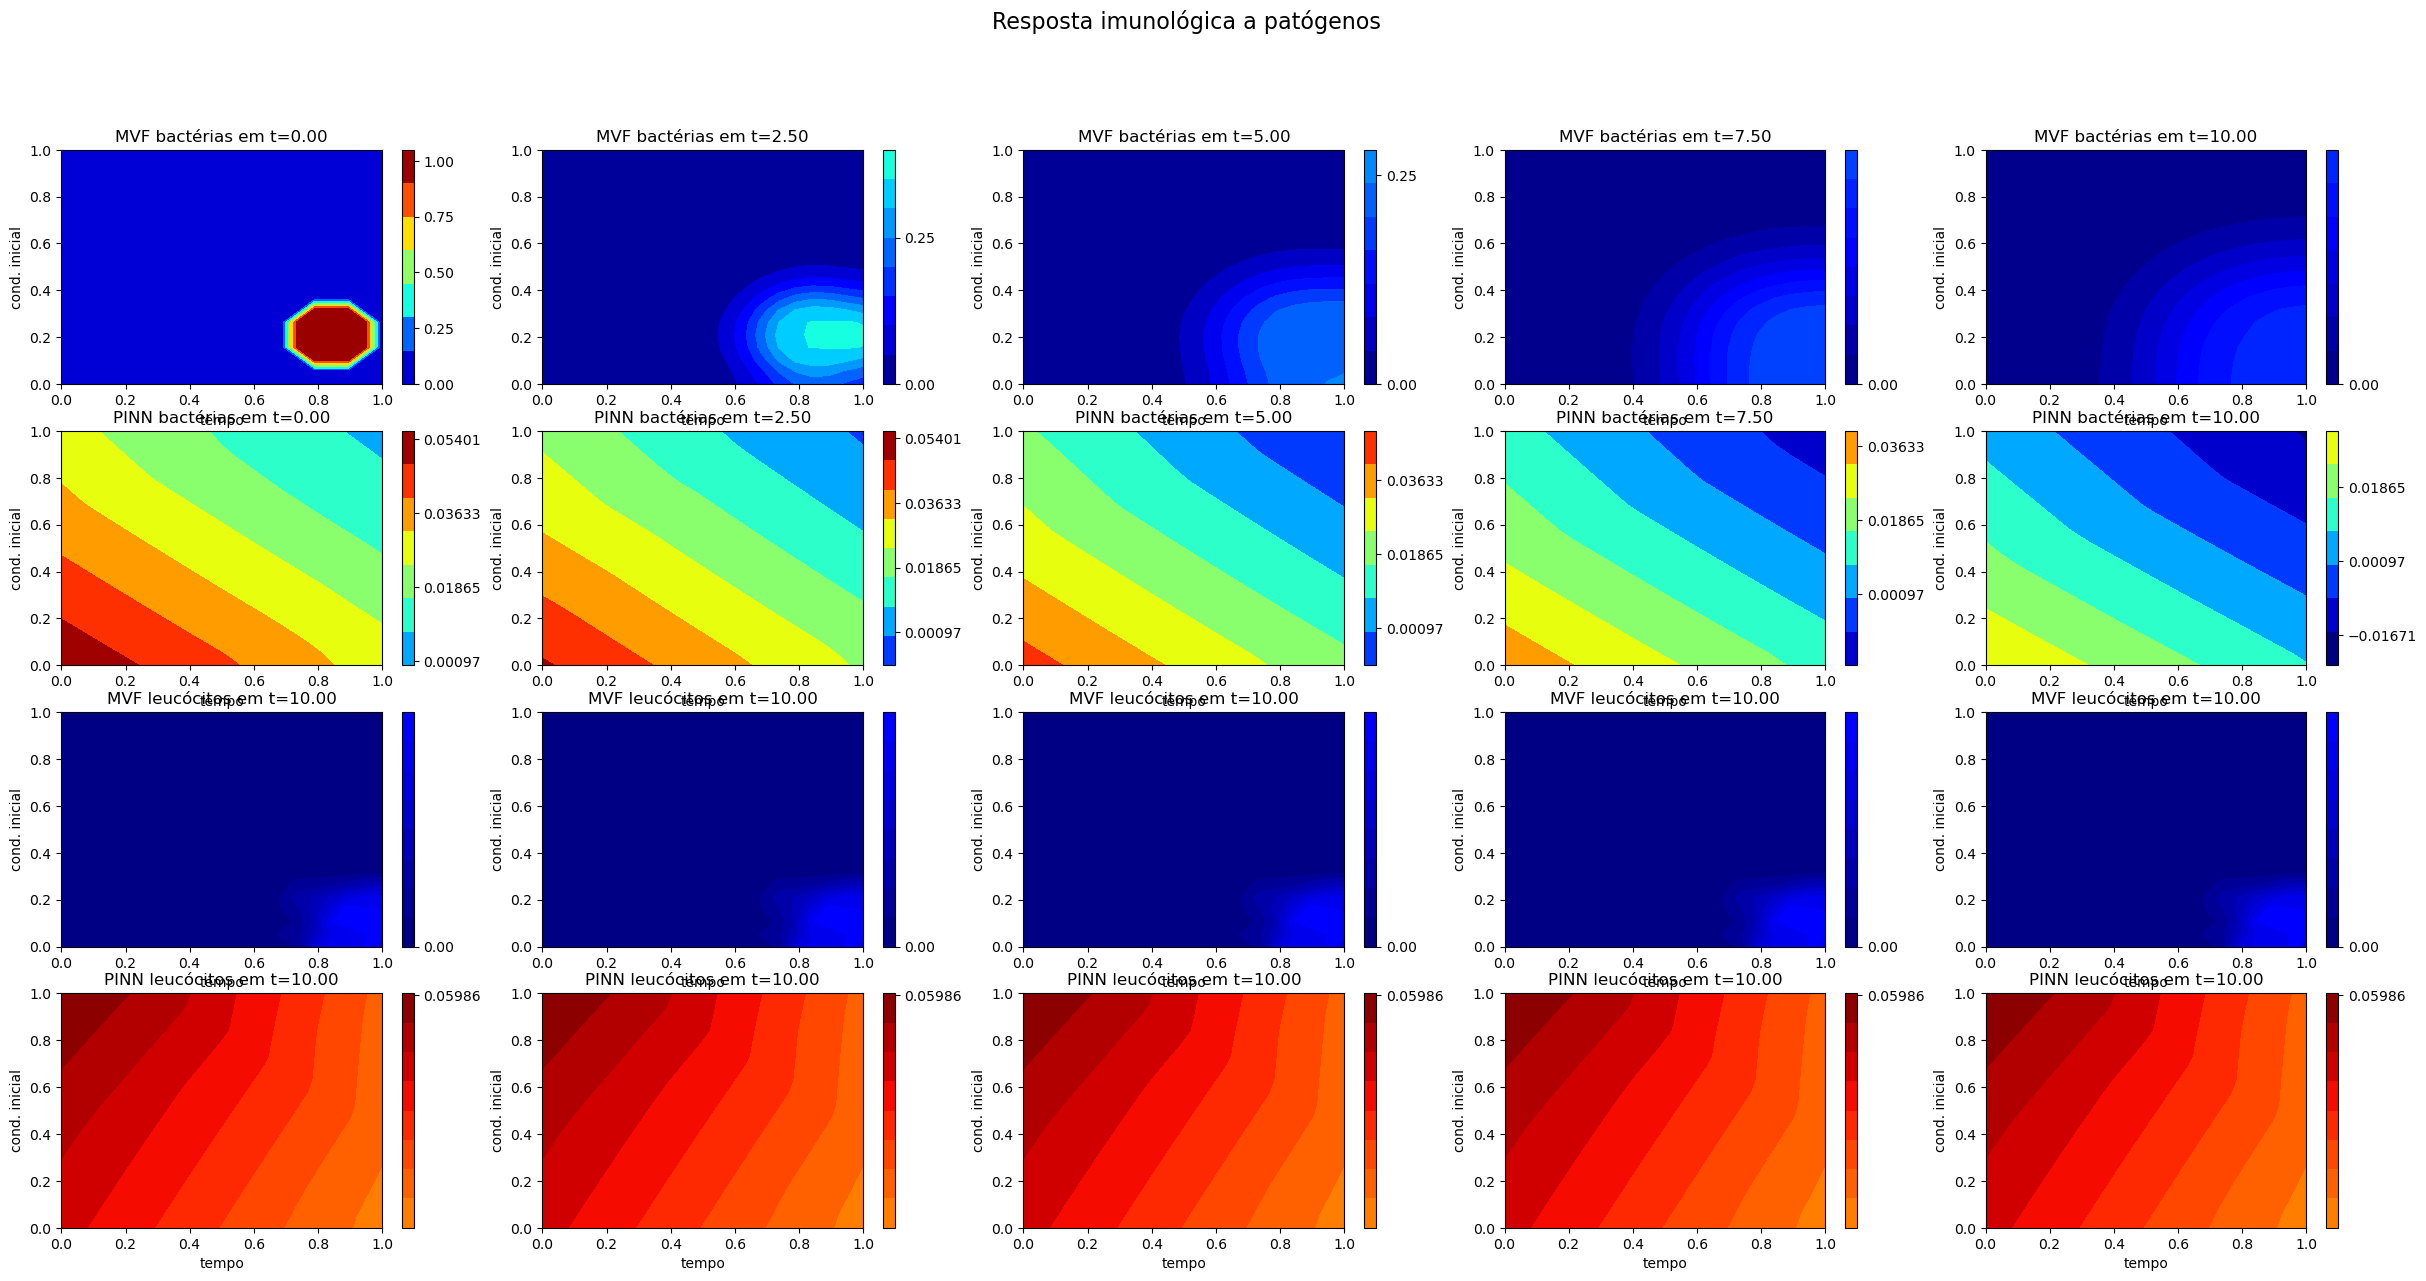

In [ ]:
t = np.linspace(t_dom[0], t_dom[-1], num=size_t, endpoint=True, dtype=np.float32)
x = np.linspace(x_dom[0], x_dom[-1], num=size_x, endpoint=True, dtype=np.float32)
y = np.linspace(y_dom[0], y_dom[-1], num=size_y, endpoint=True, dtype=np.float32)

X, Y = np.meshgrid(x, y)

time_plot = np.linspace(0, len(t) - 1, num=5, endpoint=True, dtype=int)

fig = plt.figure(figsize=[6 * len(time_plot), 14])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + 1)

    vmin = np.min(Cp_target_np)
    vmax = np.max(Cp_target_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_target_np[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("MVF bactérias em t={:.2f}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) + 1)

    vmin = np.min(Cp_pinn_np)
    vmax = np.max(Cp_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cp_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN bactérias em t={:.2f}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

for i, time_inst in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 2 + 1)

    vmin = np.min(Cl_target_np)
    vmax = np.max(Cl_target_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_target_np[it],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("MVF leucócitos em t={:.2f}".format(t[it]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))


for i, it in enumerate(time_plot):
    # Plotango 3D
    ax = fig.add_subplot(4, len(time_plot), i + len(time_plot) * 3 + 1)

    vmin = np.min(Cl_pinn_np)
    vmax = np.max(Cl_pinn_np)

    contour = ax.contourf(
        X,
        Y,
        Cl_pinn_np[time_inst],
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
    )

    ax.set_title("PINN leucócitos em t={:.2f}".format(t[time_inst]))
    ax.set_xlabel("tempo")
    ax.set_ylabel("cond. inicial")
    colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

In [21]:
from glob import glob

list_nn_parameters = glob("nn_parameters/*")

list_learning_curves = glob("learning_curves/*")

list_pinn_sim = glob("pinn_sim/*")